In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import imageio as io
import scanpy as sc
import anndata as ad
import os
import logging
from cellpose import models, io
import glob
from PIL import Image
import cv2
from tkinter import Tk     # from tkinter import Tk for Python 3.x
from tkinter import filedialog
from tkinter import *
from tkinter import ttk
from tkinter import simpledialog
from tkinter import messagebox
import tkinter as tk
import os
import logging
from cellpose import models, io
import shutil

In [2]:
def get_image(table):      
    dict_detected = {}

    xlist = d2['global_x'].astype(int).tolist()
    ylist = d2['global_y'].astype(int).tolist()
    print(len(xlist))
    for i in range(len(xlist)):
        dict_detected[xlist[i]] = []
    for i in range(len(ylist)):
        dict_detected[xlist[i]].append(ylist[i])

    #create image from transcript locations
    new_img = np.zeros((int(np.max(d2['global_x']+3000)), int(np.max(d2['global_y']+3000))))
    for i in dict_detected.keys():
        new_img[i][dict_detected.get(i)] = 1
        
    return dict_detected, new_img


messagebox.showinfo("Option","Please locate the region0 folder for the experiment")
root = Tk()
root.withdraw()
folder_selected1 = filedialog.askdirectory()

messagebox.showinfo("Option","Next question appearing shortly")
try:
    detected_tanscripts = pd.read_csv(folder_selected1+os.path.sep+'detected_transcripts.csv')
except:
    print('detected_transcripts.csv not found in the folder')
answer = simpledialog.askstring("Input", "Slices to run segmentation on (separated by commas)")
answer = answer.replace(' ', '')
answer = answer.split(',')
answer = [float(i) for i in answer]
d2 = detected_tanscripts[detected_tanscripts['global_z'].isin(answer)]
dict_detected, new_img = get_image(d2) 

2275487


In [3]:

messagebox.showinfo("Option","Please select an output folder for the experiment analysis results")
folder_selected = filedialog.askdirectory()

messagebox.showinfo("Option","Starting Cellpose")
model = models.CellposeModel(gpu=True, pretrained_model='C:/Users/amonell/Downloads/images_to_label/models/CP_20220920_113001')
# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
channels = [0,0]
masks = []
flows = []
styles = []
diams = []
ct = 0
for i in range(2000, len(new_img[0]), 2000):
    for j in range(2000, len(new_img[1]), 2000):      
        ksize = (5, 5)

        # Using cv2.blur() method 
        image = cv2.blur(new_img[i-2000:i, j-2000:j], ksize) 
        image = image * 255

        try:
            assert len(np.unique(image))>1
            masks_, flows_, styles_= model.eval([image], channels=channels, diameter=22.92,flow_threshold=0.7, cellprob_threshold=-2)
            masks.extend(masks_)
            flows.extend(flows_)
            styles.extend(styles_)
            print(ct, end = ' ')
        except (AssertionError):
            try:
                masks.append(np.zeros((len(image[0]), len(image[1]))))
                flows.append([])
                styles.append([])
            except:
                masks.append([])
                flows.append([])
                styles.append([])   
        ct += 1
temp_img_arr = []
for i in range(2000, len(new_img[0]), 2000):
    for j in range(2000, len(new_img[1]), 2000):      
        ksize = (5, 5)

        # Using cv2.blur() method 
        image = cv2.blur(new_img[i-2000:i, j-2000:j], ksize) 
        image = image * 255
        temp_img_arr.append(image)
io.save_masks(temp_img_arr, masks, flows, file_names=['stack_prestain_'+str(i).zfill(6)+'_cp_masks'+'.png' for i in range(len(temp_img_arr))], savedir = folder_selected + os.path.sep +'cellpose_predictions')
try:
    os.makedirs(folder_selected + os.path.sep +'images_for_cellpose_prediction')
except:
    None
for i in range(len(temp_img_arr)):   
    io.imsave(folder_selected + os.path.sep +'images_for_cellpose_prediction'+os.path.sep+'image-'+str(i)+'.tiff', temp_img_arr[i])
messagebox.showinfo("Option","Cellpose finished and saved to "+folder_selected)

from PIL import Image
for i in range(len(masks)):
    masks[i] = masks[i]+(i*10000)
h_list = []
for j in range(len(new_img[1])//2000):
    h_list.append(np.hstack([masks[i] for i in range(j*(len(new_img[0])//2000),  j*(len(new_img[0])//2000)+ len(new_img[0])//2000)]))
reconstruction = np.vstack(h_list)


0 1 2 3 4 6 7 8 9 10 12 13 14 15 16 18 19 20 21 22 24 25 26 27 28 30 31 32 33 34 

In [4]:
from PIL import Image
masks_read = []
for i in glob.glob(folder_selected + os.path.sep +'cellpose_predictions'+ os.path.sep+ '*.png'):
    masks_read.append(np.array(Image.open(i)))

h_list = []
for j in range(len(new_img[1])//2000):
    h_list.append(np.hstack([masks_read[i] for i in range(j*(len(new_img[0])//2000),  j*(len(new_img[0])//2000) + len(new_img[0])//2000)]))
vizualized_reconstruction = np.vstack(h_list)
io.imsave(folder_selected + os.path.sep +'cellmask_reconstruction.tiff', vizualized_reconstruction)

In [5]:
#vizualized_reconstruction = io.imread(folder_selected + os.path.sep +'cellmask_reconstruction.tiff')
vizualized_reconstruction = np.clip(vizualized_reconstruction, 0, 1)
adata = sc.read('C:/Users/amonell/Downloads/combined_filtered.h5')
gene_to_id_table = pd.read_csv('C:/Users/amonell/Downloads/geneID_to_geneName_MERSCOPE_panel1.txt', sep='\t', index_col=0)
should_explore = messagebox.askyesno('Save all top 3 gene images?', 'Should the top 3 DE gene per cluster transcript images be saved? This may take a while')
if should_explore == True:
    try:
        os.mkdir(folder_selected + os.path.sep + 'Transcript_ClusterTop3_Images')
    except:
        None
    finding_cluster_markers = adata[:,adata.var.index.isin(set(gene_to_id_table['gene_name']))]
    sc.tl.rank_genes_groups(finding_cluster_markers, groupby='seurat_clusters')
    top3_DE = [i for i in finding_cluster_markers.uns['rank_genes_groups']['names']][:3]
    top3_list = []
    for i in range(len(top3_DE[0])):
        top3_list.append([top3_DE[0][i], top3_DE[1][i], top3_DE[2][i]])

    def display_gene_spatial(cell_image, gene_name, detected_transcript_df, cluster):
        toplot = gene_to_id_table[gene_to_id_table['gene_name'] == gene_name]['gene_id']
        xandy = detected_transcript_df[detected_transcript_df['gene'] == toplot.tolist()[0]]
        x = xandy['global_x'].tolist()
        y = xandy['global_y'].tolist()
        plt.figure(figsize=(10, 10), dpi=100)
        plt.ylim(len(cell_image.T),0)
        plt.imshow(cell_image.T, vmax = 2.3, cmap = 'Greys_r')
        plt.scatter(x, y, s = 0.15, color = 'cyan')
        plt.title('Experiment '+ os.path.basename(folder_selected)+': Gene - '+gene_name+', Marker for Cluster '+str(cluster))
        plt.savefig(folder_selected + os.path.sep + 'Transcript_ClusterTop3_Images'+os.path.sep + os.path.basename(folder_selected)+' - Gene - '+gene_name.split('.')[0].replace('/', '')+', Marker for Cluster '+str(cluster))
        plt.close()

    for i in range(len(top3_list)):
        for j in range(len(top3_list[0])):
            print(top3_list[i][j])
            display_gene_spatial(vizualized_reconstruction, top3_list[i][j], detected_tanscripts, i)   

C:\Users\amonell\Anaconda3\envs\vizgen_cellpose\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
C:\Users\amonell\Anaconda3\envs\vizgen_cellpose\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\amonell\Anaconda3\envs\vizgen_cellpose\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) ins

ndhU
AT1G49010
AT1G22630
LTP7
RGF9
NAC035
WRKY47
DML2
STP1
WRKY40
ACA1
EDS1
VSP2
ML3
GLL23
WRKY8
GLR2.5
BEH3
IAA28
RBOHF
MYB88
EFM
WRKY17
AT4G14020
MYC2
TIFY6B
VSP2
WRKY40
WRKY6
LTP7
NAC047
NAC92
anac075
KAN2
C/VIF1
BZIP9
VSP2
ML3
RAP2-6
LTP7
HDG1
WRKY8
HTA6
DMT1
GATA15
LTP7
GLL23
MYC2
ANAC13
BEH3
WRKY8
VSP2
LTP7
MYC2
WRKY42
AT-GTL1
LTP7
ACA1
AT4G24350
GAF1
WRKY40
MYB15
ERF043
RDR1
AT4G24350
ATHB-7
LTP7
DML2
SPL14
AT2G01818
HAT2
FAO3
IDD4
NAC062
RBOHF


In [4]:
gene_list = np.unique(detected_tanscripts['gene'])
cell_list = np.unique(reconstruction, return_counts=True)[0]
cell_by_gene = pd.DataFrame(columns=gene_list, index=cell_list.astype(int))
cell_by_gene = cell_by_gene.fillna(0)
postions_not_in = []
ct = 0
for i in tqdm(gene_list):
    hold_part = detected_tanscripts[detected_tanscripts['gene'] == i]
    x_part = hold_part['global_x'].astype(int).tolist()
    y_part = hold_part['global_y'].astype(int).tolist()   
    for k in range(len(x_part)):
        try:
            value_at = reconstruction[x_part[k]][y_part[k]]
            cell_by_gene.loc[value_at][i] += 1 
        except:
            postions_not_in.append((x_part,y_part, i))
    ct += 1
    print(ct, end = ' ')
cell_by_gene.to_csv(folder_selected + os.path.sep + 'cell_by_gene.csv', index=False)

  0%|          | 0/550 [00:00<?, ?it/s]

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

C:\Users\amonell\AppData\Local\Temp\ipykernel_27576\385104355.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['transcripts_per_cell'] = num_transcripts
C:\Users\amonell\Anaconda3\envs\vizgen_cellpose\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\amonell\Anaconda3\envs\vizgen_cellpose\lib\site-packages\scanpy\preprocessing\_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


C:\Users\amonell\Anaconda3\envs\vizgen_cellpose\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


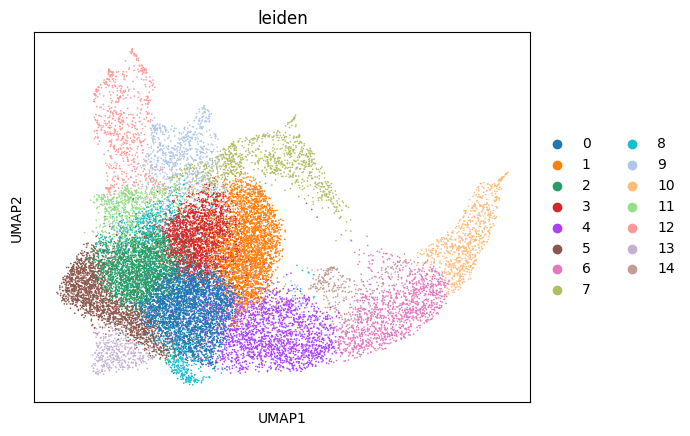

C:\Users\amonell\Anaconda3\envs\vizgen_cellpose\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


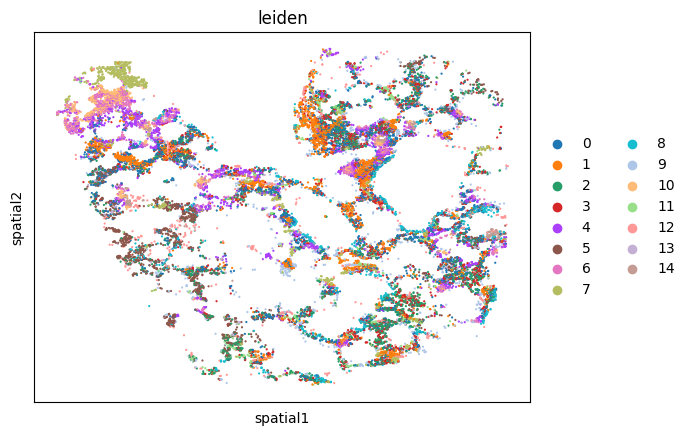

In [6]:

adata = sc.read(folder_selected + os.path.sep + 'cell_by_gene.csv')
adata.obs.index = cell_by_gene.index
total_unique = []
for i in range(len(masks)):
#     print(np.unique(masks[i], return_counts=True)[0])
    [total_unique.append(j) for j in np.unique(masks[i], return_counts=True)[1]]
adata.obs['area'] = total_unique
unique_cells_index = np.unique(reconstruction, return_index=True)[1]
spatial = []
for i in range(len(unique_cells_index)):
    spatial.append([unique_cells_index[i] % len(reconstruction[0]), unique_cells_index[i] // len(reconstruction[0])])
adata.obsm['X_spatial'] = np.array(spatial)
adata = adata[adata.obs.index.astype(int) % 10000 != 0]
num_transcripts = list(np.sum(adata.X, axis=1))
adata.obs['transcripts_per_cell'] = num_transcripts
total_gene = list(np.sum(adata.X, axis=0))
adata.var['total_gene_counts'] = total_gene
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4, multi_panel=True, title = 'Counts per Gene', save = '_quality_metrics_cpg.png')
sc.pl.violin(adata, ['total_counts'], jitter=0.4, multi_panel=True, title = 'Total Gene Counts Per Cell', save = '_quality_metrics_tgc.png')
#normalization
for i in range(len(adata.X)):
    #by area
    #adata.X[i] /= total_unique[i]
    #by tpc
    adata.X[i] /= num_transcripts[i]
adata = adata[adata.obs['transcripts_per_cell'] >= 50]
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

sc.pl.umap(adata, color='leiden', vmax=0.05, save = '_leiden.png')
sc.pl.embedding(adata, basis='spatial', color='leiden', vmax=0.05, size=10, save = '_leiden.png')
adata.write(folder_selected + os.path.sep + 'adata.h5ad')
source = r'C:\Users\amonell\Desktop\Scripts_Alex\MERSCOPE_PIPELINE\figures'
destination = folder_selected
allfiles = ['umap_leiden.png', 'spatial_leiden.png', '*_quality_metrics_cpg.png', '*_quality_metrics_tgc.png']
for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    shutil.move(src_path, dst_path)

# For training on the 2 slice set

In [ ]:
import cv2
#create cellpose images for labeling
for i in range(2000, len(new_img[0]), 2000):
    for j in range(2000, len(new_img[1]), 2000):      
        plt.imshow(new_img[i-2000:i, j-2000:j], vmax=1, cmap='gray')
        plt.show()
        value = input("y or n")
        if value == 'y':
            io.imsave(r'C:\Users\amonell\Downloads\label_cellpose_images_allslice\labeling'+str(i)+'_to_'+str(j)+'.tiff', new_img[i-2000:i, j-2000:j])

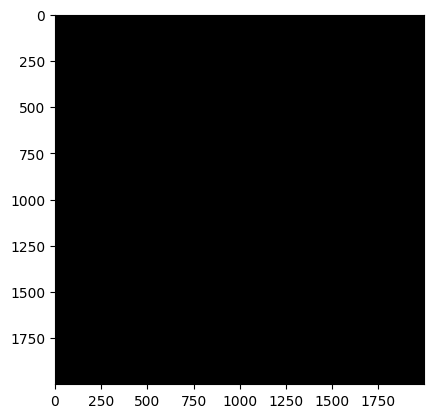

y or nn


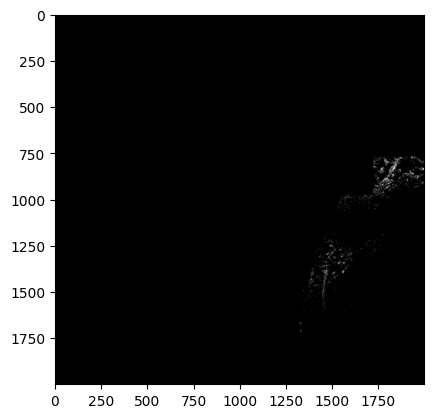

y or nn


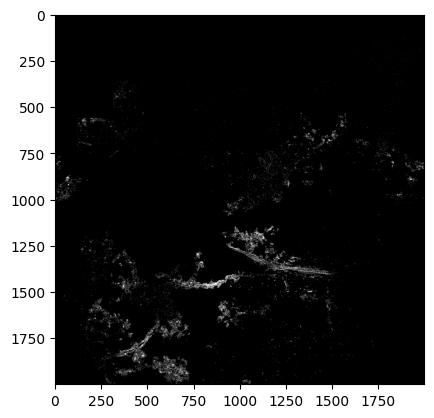

y or ny


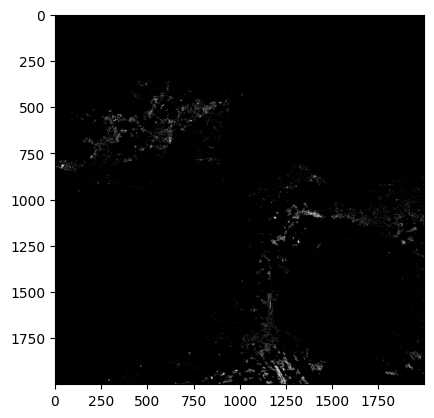

y or ny


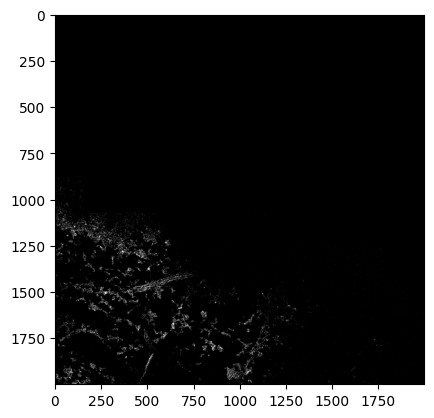

y or ny


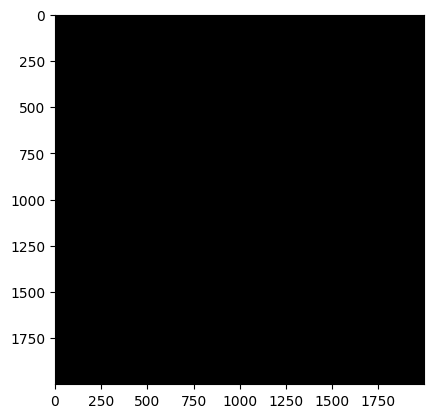

y or nn


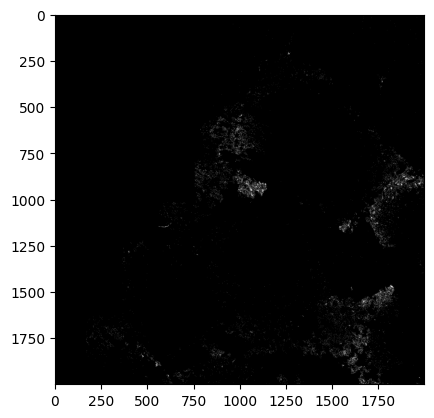

y or ny


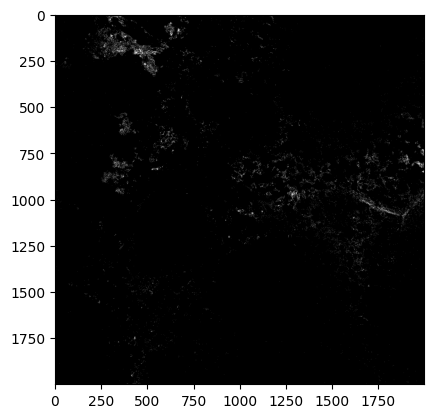

y or ny


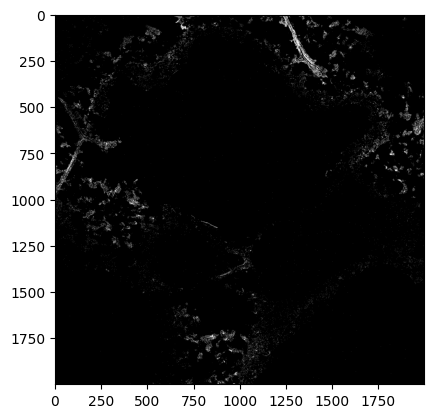


KeyboardInterrupt



In [10]:
import cv2
#used to create images for cellpose training
for i in range(2000, len(new_img[0]), 2000):
    for j in range(2000, len(new_img[1]), 2000):      
        plt.imshow(new_img[i-2000:i, j-2000:j], vmax=1, cmap='gray')
        plt.show()
        value = input("y or n")
        if value == 'y':
            # ksize
            ksize = (5, 5)

            # Using cv2.blur() method 
            image = cv2.blur(new_img[i-2000:i, j-2000:j], ksize) 
            image = image * 255
            io.imsave(r'C:\Users\amonell\Downloads\transcript_images_to_label_slice3\training'+str(i)+'_to_'+str(j)+'.tiff', image)

# For training on all slices

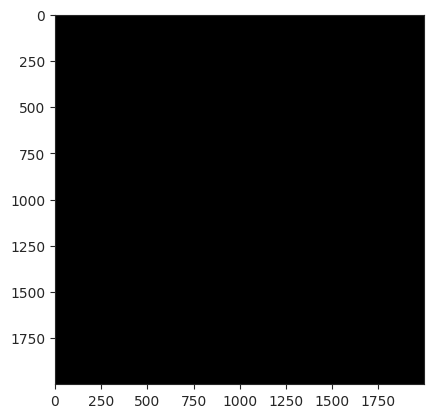

y or nn


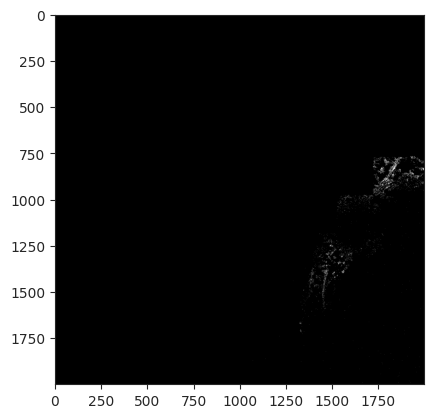

y or nn


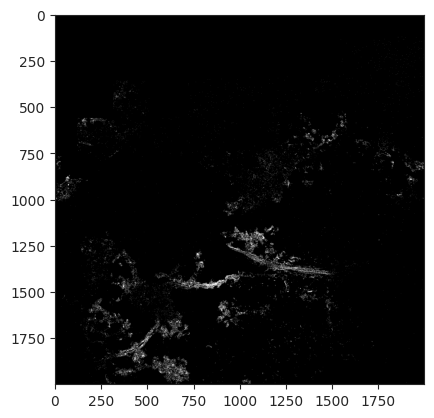

y or ny


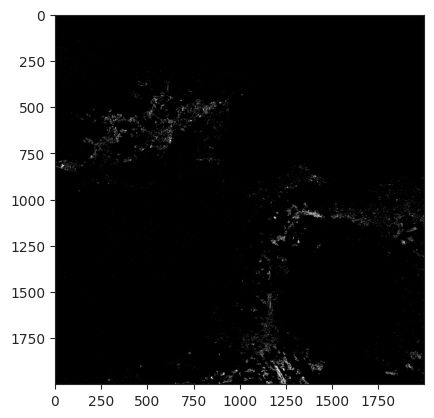

y or ny


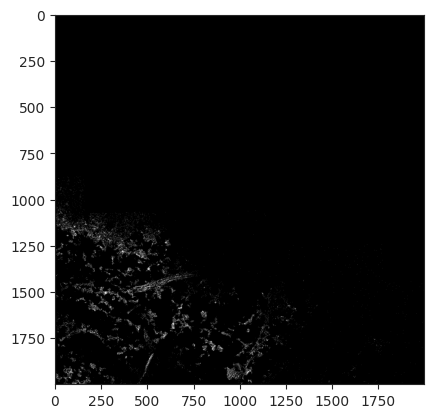

y or ny


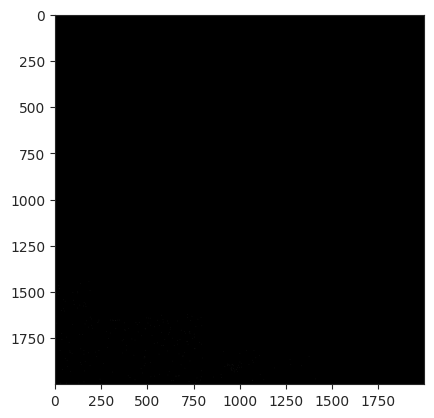

y or nn


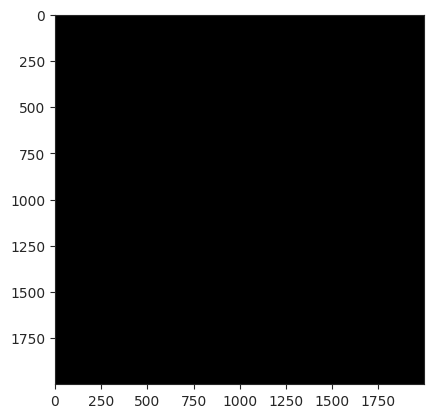

y or nn


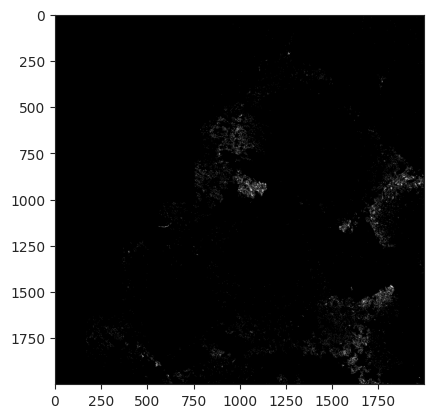

y or ny


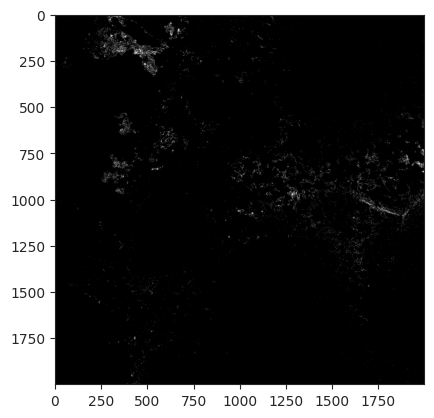

y or ny


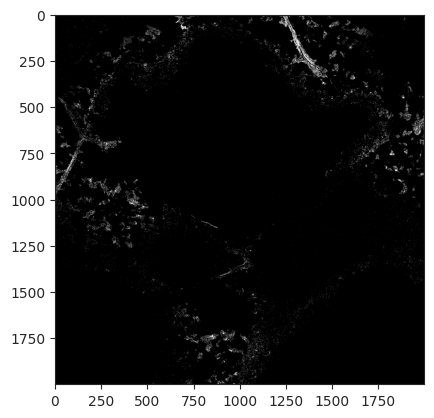

y or ny


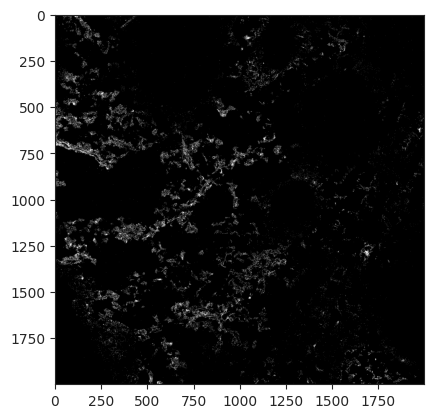

y or ny


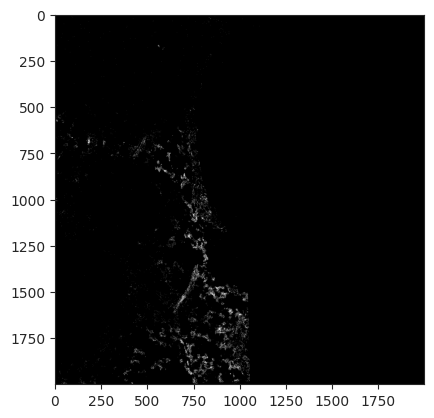

KeyboardInterrupt: Interrupted by user

In [499]:
import cv2
#create cellpose images for labeling
for i in range(2000, len(new_img_all[0]), 2000):
    for j in range(2000, len(new_img_all[1]), 2000):      
        plt.imshow(new_img_all[i-2000:i, j-2000:j], vmax=1, cmap='gray')
        plt.show()
        value = input("y or n")
        if value == 'y':
            io.imsave(r'C:\Users\amonell\Downloads\label_cellpose_images_allslice\labeling'+str(i)+'_to_'+str(j)+'.tiff', new_img[i-2000:i, j-2000:j])

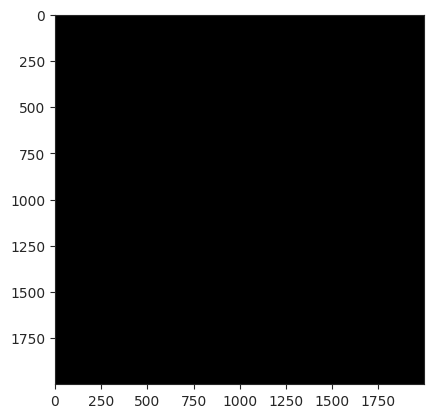

y or nn


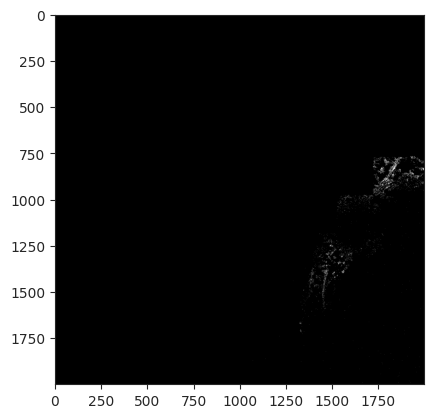

y or nn


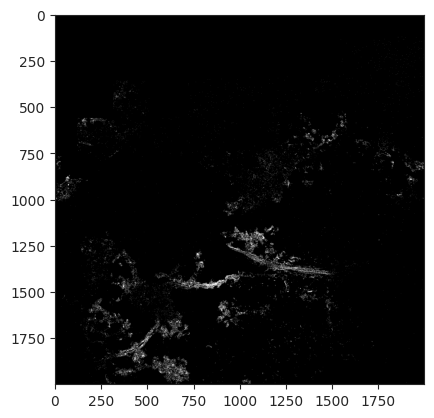

y or ny


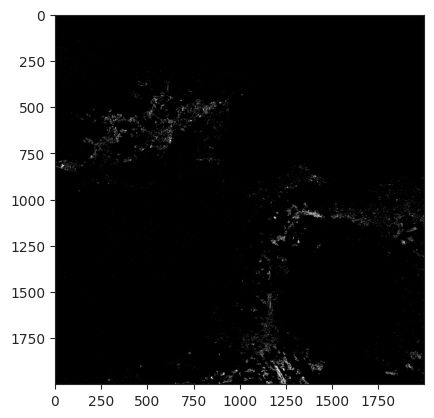

y or ny


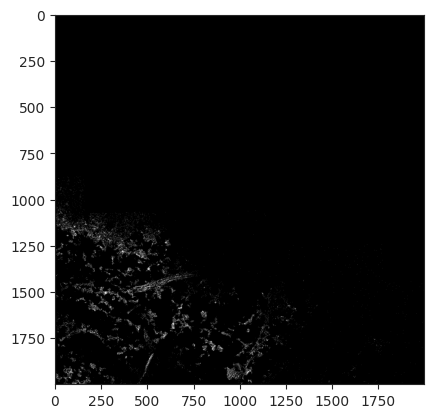

y or ny


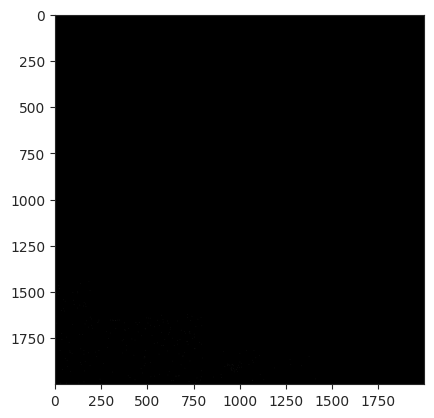

y or nn


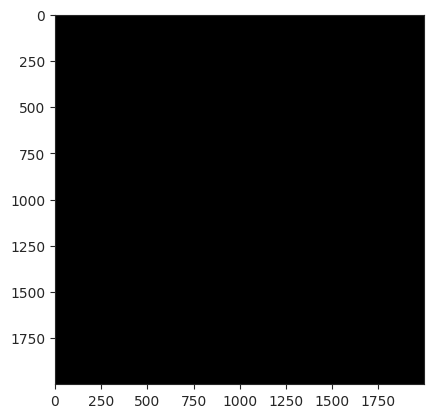

y or nn


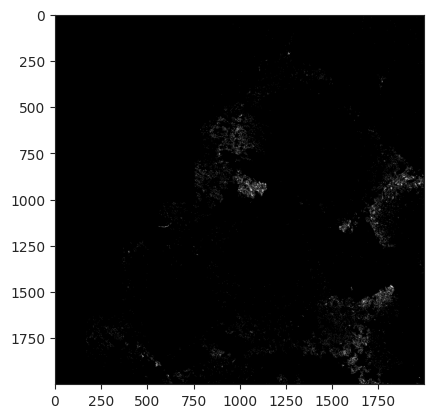

y or ny


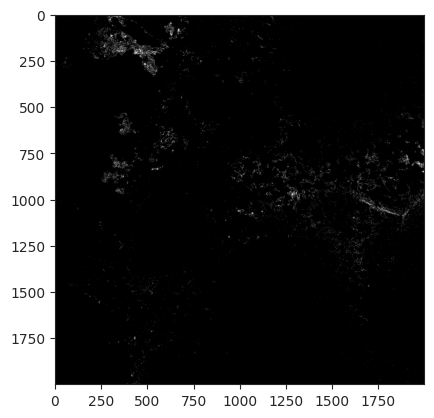

y or ny


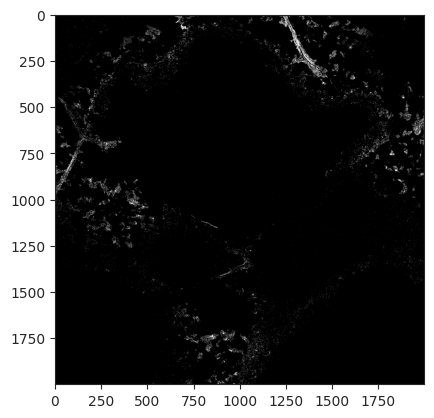

y or ny


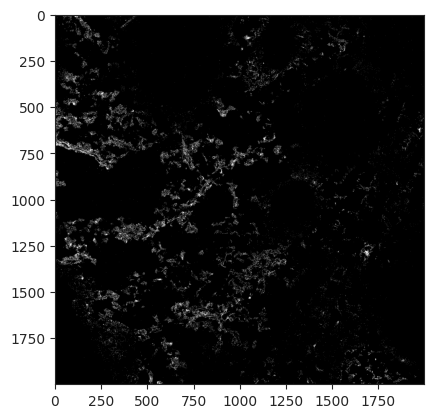

y or ny


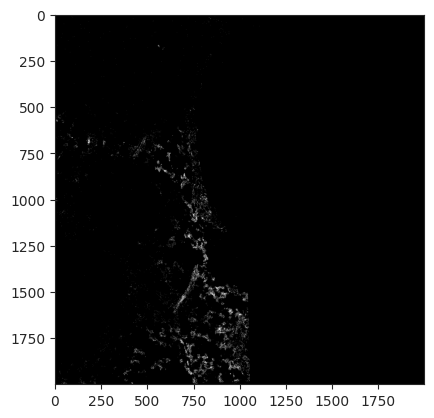

y or ny


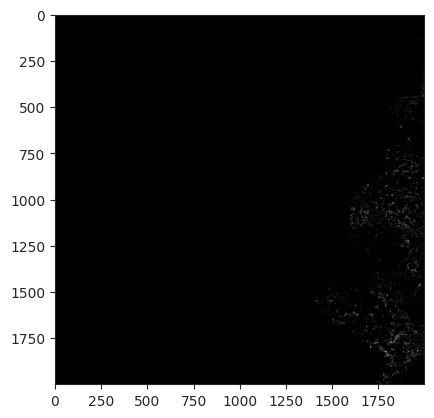

KeyboardInterrupt: Interrupted by user

In [500]:
import cv2
#used to create images for cellpose training
for i in range(2000, len(new_img_all[0]), 2000):
    for j in range(2000, len(new_img_all[1]), 2000):      
        plt.imshow(new_img_all[i-2000:i, j-2000:j], vmax=1, cmap='gray')
        plt.show()
        value = input("y or n")
        if value == 'y':
            # ksize
            ksize = (5, 5)

            # Using cv2.blur() method 
            image = cv2.blur(new_img_all[i-2000:i, j-2000:j], ksize) 
            image = image * 255
            io.imsave(r'C:\Users\amonell\Downloads\label_cellpose_images_allslice\training'+str(i)+'_to_'+str(j)+'.tiff', image)

In [ ]:
# show spatial relationships of different celltype subclusters
# change batch normalization
# overlay individual transcripts with cell plot to see if certain celltypes are being missed
# use Hanqings integration for tf spatial 